In [22]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results_path=r's3://aind-scratch-data/dynamic-routing/decoding/results/v265_0_consolidated.parquet'

session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [3]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [9]:
# structure-wise average decoding accuracy

new_results_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
        pl.col('session_id').n_unique().ge(3).over('structure', 'unit_subsample_size')#, 'unit_criteria'),
    )
    # get the means for each recording over their shifts:
    .group_by(grouping_cols | {'repeat_idx'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median().alias('median_null'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().sub(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median()
        ).alias('mean_diff')
    )
    # get the means over repeats:
    .group_by(grouping_cols)
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean()
    )
    # get the means over sessions:
    .group_by('structure', 'unit_subsample_size')#, 'unit_criteria')
    .agg(
        pl.col('mean_true').mean(),
        pl.col('mean_true').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_true'),
        pl.col('median_null').mean(),
        pl.col('median_null').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_null'),
        pl.col('mean_diff').mean(),
        pl.col('mean_diff').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_diff'),
        pl.col('session_id').n_unique().alias('num_sessions')
    )
    .sort(pl.col('mean_diff').mean().over('structure'), descending=True)
    .collect()
)



In [63]:
new_results_df.to_pandas().query('structure.str.contains("SC")')['structure'].unique()

array(['SCiw', 'SCm', 'SCig', 'SCdg', 'VISC', 'SCop', 'SCs', 'SCsg'],
      dtype=object)

In [10]:
new_results_pd=new_results_df.to_pandas()
new_results_pd

structure  unit_subsample_size  mean_true  sem_true  median_null  \
0        SCiw                  NaN   0.771471  0.019500     0.634977   
1        SCiw                 20.0   0.822718  0.016810     0.659734   
2        SCiw                 10.0   0.760572  0.017992     0.633488   
3        SCiw                 30.0   0.815342  0.029773     0.640367   
4         SCm                 40.0   0.828921  0.016578     0.658778   
..        ...                  ...        ...       ...          ...   
406       LSc                  NaN   0.549085  0.021233     0.544195   
407       LSc                 30.0   0.547681  0.019658     0.544166   
408       LSc                 40.0   0.547417  0.031098     0.556096   
409        NB                  NaN   0.512878  0.011146     0.523976   
410        IG                  NaN   0.517554  0.037829     0.533954   

     sem_null  mean_diff  sem_diff  num_sessions  
0    0.010596   0.136495  0.011177            30  
1    0.016064   0.162984  0.008591            11  
2    0.010439   0.127084  0.010170            19  
3    0.019355   0.174976  0.011197             5  
4    0.008715   0.170142  0.009912            12  
..        ...        ...       ...           ...  
406  0.015181   0.004890  0.010336             7  
407  0.014382   0.003515  0.014896             4  
408  0.022024  -0.008679  0.009177             3  
409  0.006621  -0.011099  0.008073             3  
410  0.013045  -0.016400  0.027124             3  

[411 rows x 9 columns]

In [64]:
#filter out specific SC substructures
new_results_pd = new_results_pd[~new_results_pd['structure'].str.contains('SCzo|SCop|SCsg|SCiw|SCig|SCdw|SCdg')]

In [65]:
new_results_pd.query('structure.str.contains("SC")')['structure'].unique()

array(['SCm', 'VISC', 'SCs'], dtype=object)

In [ ]:
# new_results_pd.to_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\structure_wise_decoding_accuracy.csv",index=False)

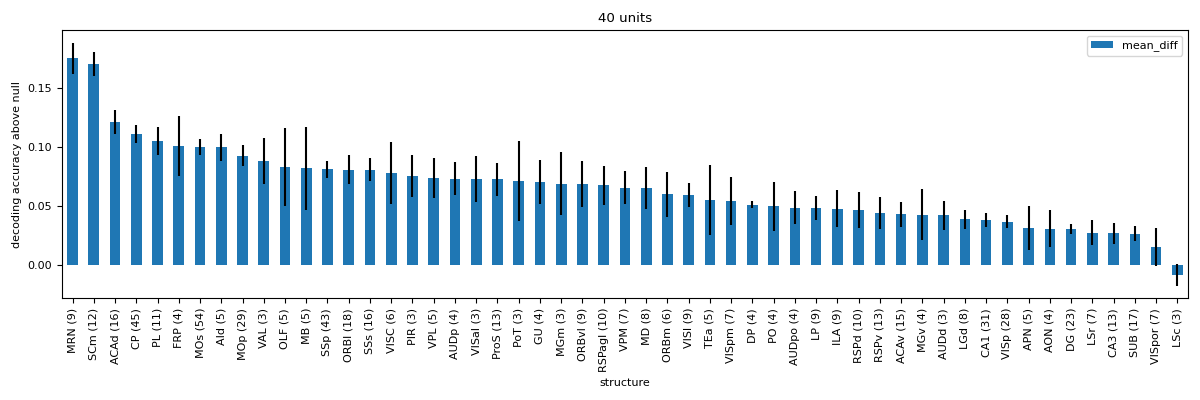

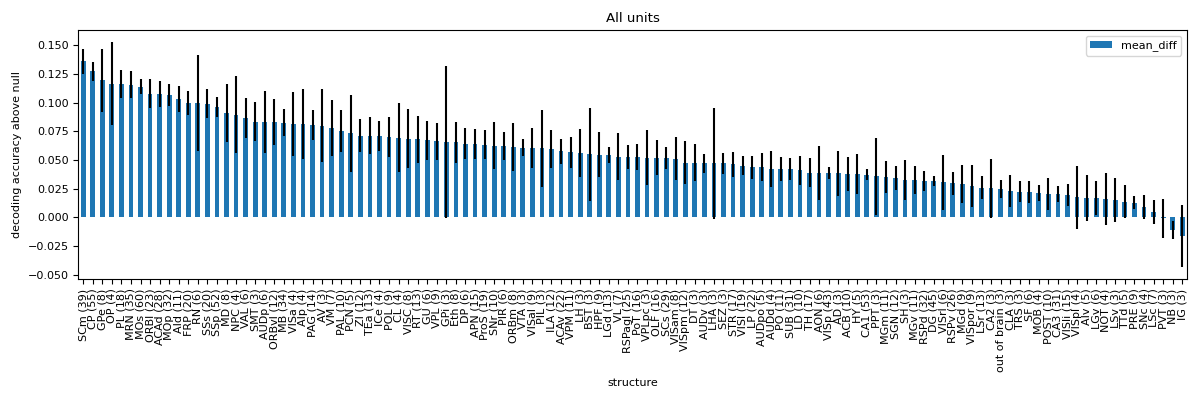

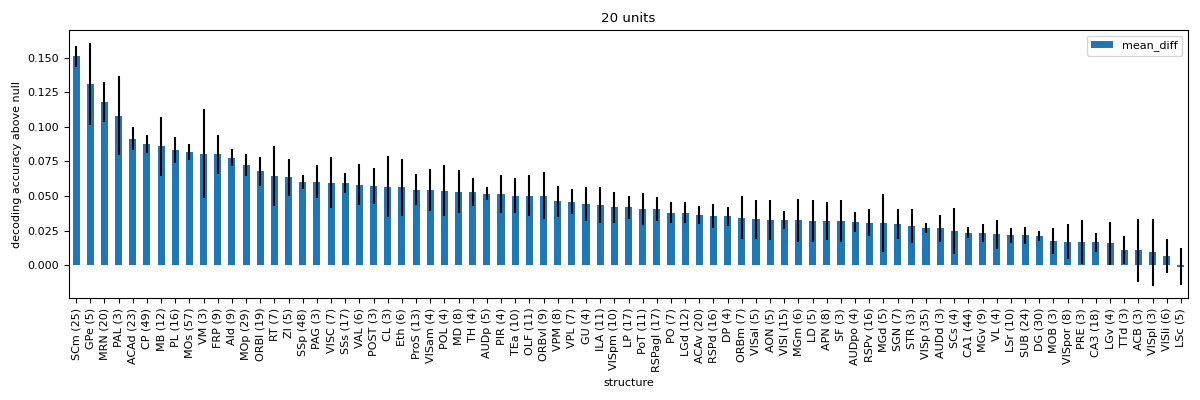

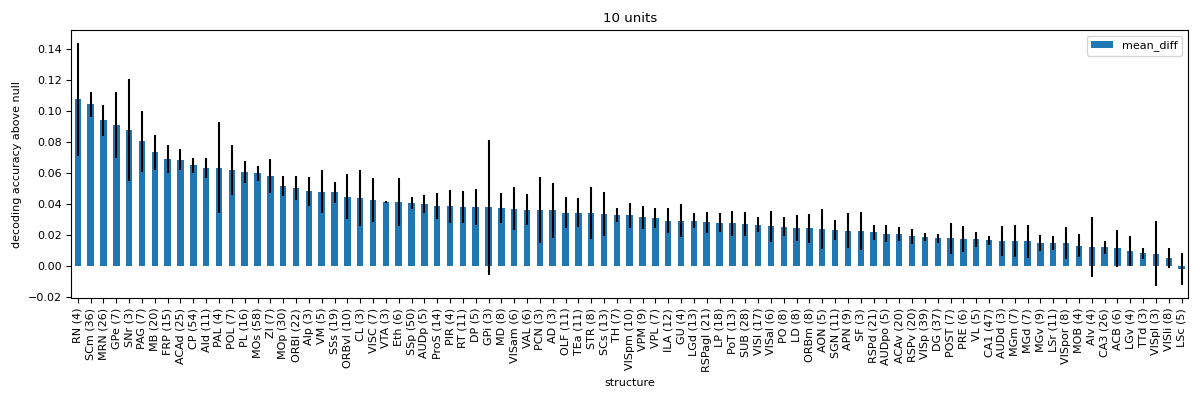

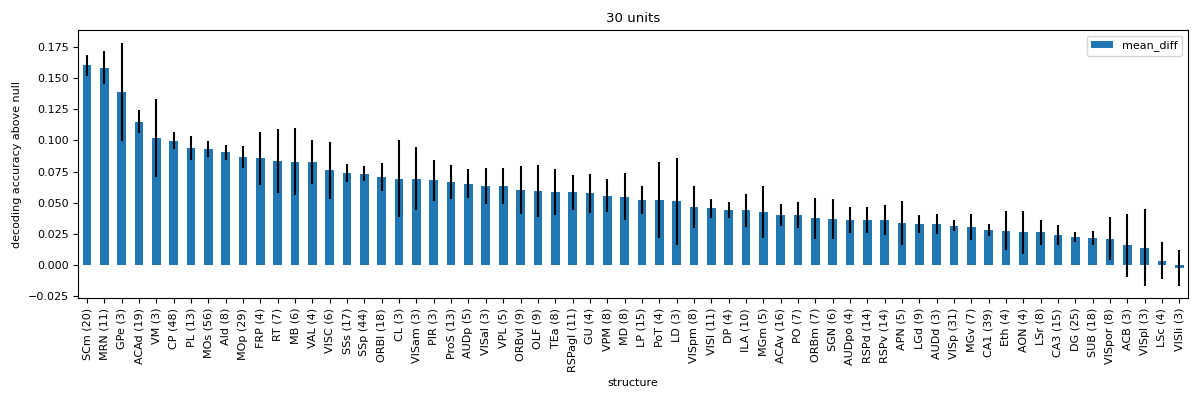

In [66]:
for uu in new_results_pd['unit_subsample_size'].unique():
    fig,ax=plt.subplots(1,1,figsize=(12,4))
    structure_labels=[]
    if np.isnan(uu):
        plot_data=new_results_pd.query('unit_subsample_size.isna()').sort_values(by='mean_diff',ascending=False)
        plot_data.plot.bar(ax=ax,x='structure',y=['mean_diff'],yerr='sem_diff',rot=90)
        title_str='All units'
        for i in range(plot_data.shape[0]):
            structure_labels.append(plot_data['structure'].iloc[i]+' ('+str(int(plot_data['num_sessions'].iloc[i]))+')')
    else:
        plot_data=new_results_pd.query('unit_subsample_size==@uu').sort_values(by='mean_diff',ascending=False)
        plot_data.plot.bar(ax=ax,x='structure',y=['mean_diff'],yerr='sem_diff',rot=90)
        title_str=f'{int(uu)} units'
        for i in range(plot_data.shape[0]):
            structure_labels.append(plot_data['structure'].iloc[i]+' ('+str(int(plot_data['num_sessions'].iloc[i]))+')')

    
    ax.set_ylabel('decoding accuracy above null')
    ax.set_title(title_str)
    ax.set_xticklabels(structure_labels,rotation=90,ha='center')
    fig.tight_layout()


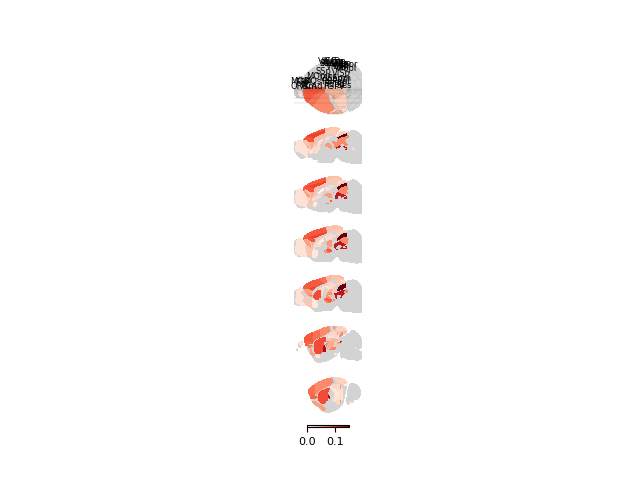

In [69]:
#plot on CCF

sel_n_units=20

if sel_n_units == 'all':
    query_string='unit_subsample_size.isna()'
else:
    query_string='unit_subsample_size==@sel_n_units'

chart,x = plot_utils.plot_brain_heatmap(
    regions=new_results_pd.query(query_string)['structure'],
    values=new_results_pd.query(query_string)['mean_diff'],
    sagittal_planes=(-250,-500,-750,-1000,-2000,-3000),
    cmap='Reds',
    clevels=(0,0.15),
    labels=True,
    labels_on_areas=True,
    interactive=True,
    annotation_params={
        'fontsize':6,
    }
)

In [ ]:
### gap between SCs and SCm -- Why??


In [70]:
chart.show()

alt.HConcatChart(...)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_44600\3235480877.py:30: RuntimeWarning: invalid value encountered in cast
  ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_44600\3235480877.py:30: RuntimeWarning: invalid value encountered in cast
  ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_44600\3235480877.py:30: RuntimeWarning: invalid value encountered in cast
  ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_44600\3235480877.py:30: RuntimeWarning: invalid value encountered in cast
  ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_44600\3235480877.py:30: RuntimeWarning: invalid 

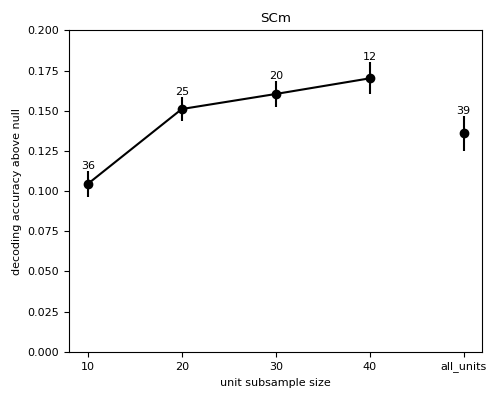

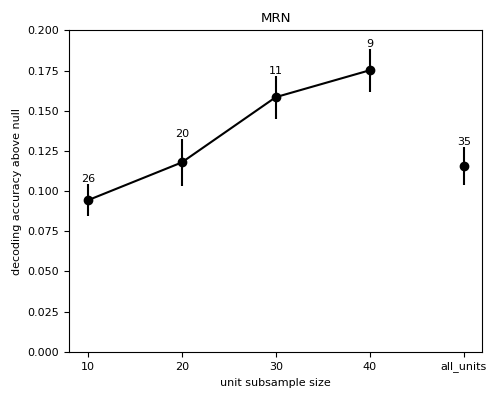

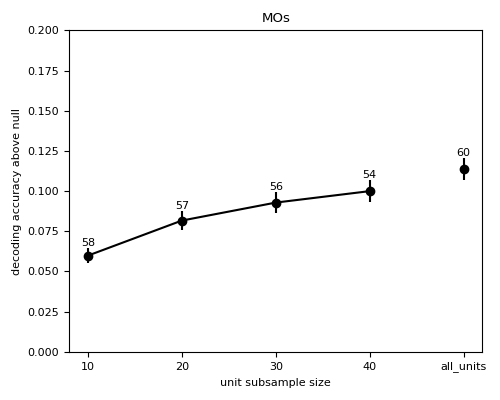

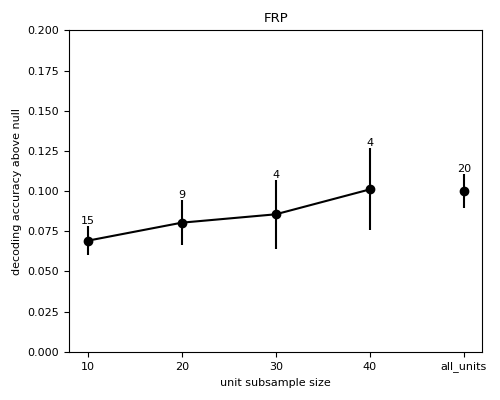

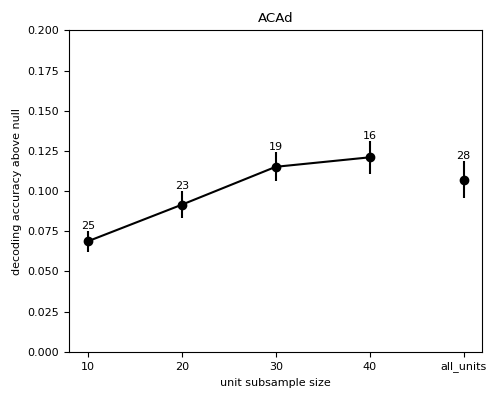

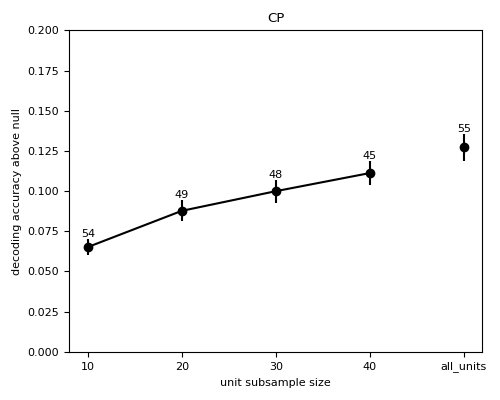

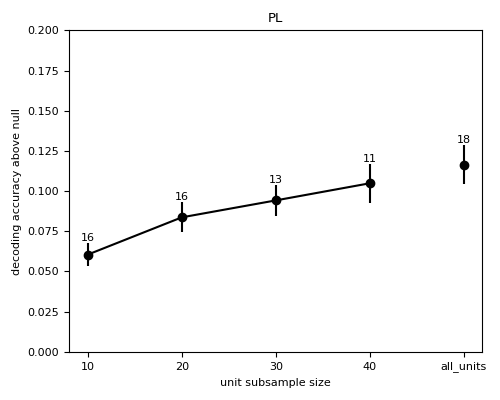

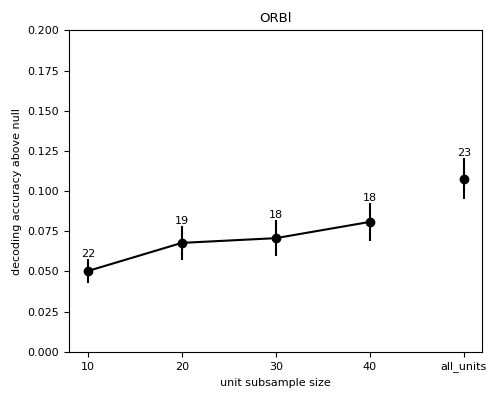

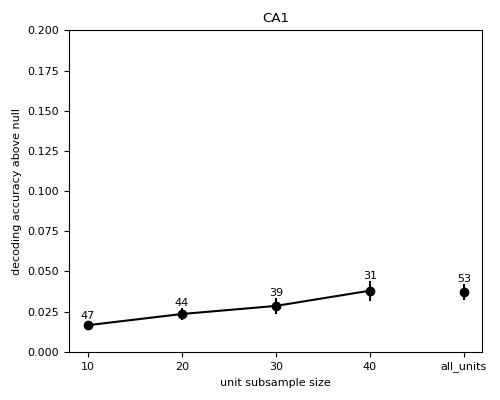

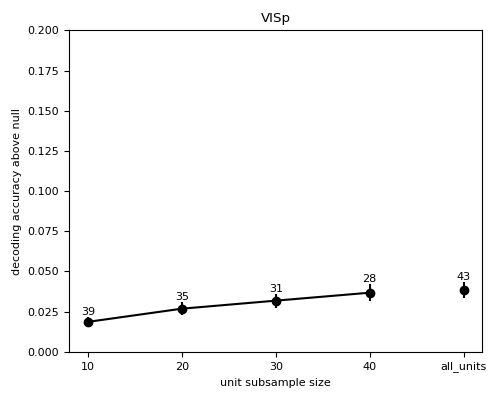

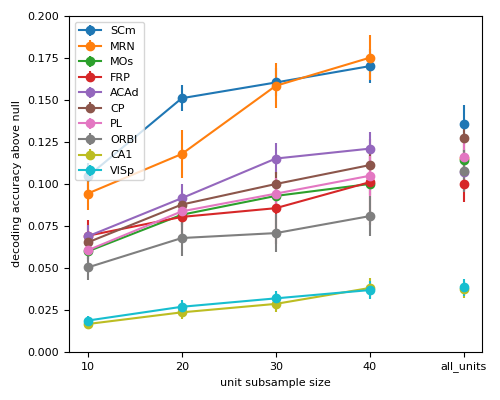

In [71]:
#accuracy vs. n units for a subset of structures
sel_structures=['SCm','MRN','MOs','FRP','ACAd','CP','PL','ORBl','CA1','VISp']

for ss in sel_structures:
    fig,ax=plt.subplots(1,1,figsize=(5,4))
    plot_data=new_results_pd.query('structure==@ss').sort_values(by='mean_diff',ascending=True)

    ax.errorbar(plot_data.query('~unit_subsample_size.isna()')['unit_subsample_size'],
                plot_data.query('~unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('~unit_subsample_size.isna()')['sem_diff'],marker='o',color='k')
    ax.errorbar(np.nanmax(plot_data['unit_subsample_size'])+10,
                plot_data.query('unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('unit_subsample_size.isna()')['sem_diff'],marker='o',color='k')
    
    for uu in plot_data['unit_subsample_size'].unique():
        if np.isnan(uu):
            xcoord=np.nanmax(plot_data['unit_subsample_size'])+10
            ycoord=plot_data.query('unit_subsample_size.isna()')[['mean_diff','sem_diff']].sum(axis=1).values[0]
            temp_str=plot_data.query('unit_subsample_size.isna()')['num_sessions'].values[0]
        else:
            xcoord=uu
            ycoord=plot_data.query('unit_subsample_size==@uu')[['mean_diff','sem_diff']].sum(axis=1).values[0]
            temp_str=plot_data.query('unit_subsample_size==@uu')['num_sessions'].values[0]

        ax.text(xcoord,ycoord,temp_str,ha='center',va='bottom')

    ax.set_ylabel('decoding accuracy above null')
    ax.set_xlabel('unit subsample size')
    ax.set_xticks(plot_data['unit_subsample_size'].unique().tolist()+[np.nanmax(plot_data['unit_subsample_size'])+10])
    ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
    ax.set_title(ss)
    ax.set_ylim([0,0.2])
    fig.tight_layout()

#plot all on same figure
fig,ax=plt.subplots(1,1,figsize=(5,4))
for ss in sel_structures:
    plot_data=new_results_pd.query('structure==@ss').sort_values(by='mean_diff',ascending=True)

    line=ax.errorbar(plot_data.query('~unit_subsample_size.isna()')['unit_subsample_size'],
                plot_data.query('~unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('~unit_subsample_size.isna()')['sem_diff'],marker='o',label=ss)
    ax.errorbar(np.nanmax(plot_data['unit_subsample_size'])+10,
                plot_data.query('unit_subsample_size.isna()')['mean_diff'],
                yerr=plot_data.query('unit_subsample_size.isna()')['sem_diff'],marker='o',
                color=line[0].get_color())
    
ax.legend()
ax.set_ylabel('decoding accuracy above null')
ax.set_xlabel('unit subsample size')
ax.set_xticks(plot_data['unit_subsample_size'].unique().tolist()+[np.nanmax(plot_data['unit_subsample_size'])+10])
ax.set_xticklabels(plot_data['unit_subsample_size'].unique().astype(int).tolist()+['all_units'])
ax.set_ylim([0,0.2])
fig.tight_layout()

In [39]:
# session-wise average decoding accuracy
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = True
if keep_original_structure:
    n_repeats = 2

#add total n units, cross-modal dprime, n good blocks?

new_results_session_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
    )
    #get total n units
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    #join on session table to get cross-modal dprime, etc.
    .join(
        other=session_table.filter(
            pl.col('session_id').is_in(dr_session_list)
        ).select(
            'session_id',
            'n_passing_blocks',
            'cross_modal_dprime_vis_blocks',
            'cross_modal_dprime_aud_blocks',
        ).lazy(),
        on='session_id',
        how='left',
    )
    # get the means for each recording over their shifts:
    .group_by(grouping_cols | {'repeat_idx', 'n_passing_blocks', 'cross_modal_dprime_vis_blocks', 
                               'cross_modal_dprime_aud_blocks', 'total_n_units'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median().alias('median_null'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().sub(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median()
        ).alias('mean_diff'),
        pl.col('balanced_accuracy_test').alias('accuracy_across_shifts'),
        pl.col('shift_idx'),

    )
    # .explode('accuracy_across_shifts','shift_idx')
    # .group_by(grouping_cols | 'n_passing_blocks', 'cross_modal_dprime_vis_blocks', 
    #                             'cross_modal_dprime_aud_blocks', 'total_n_units')
    # .agg(
    #     pl.col('mean_true').first(),
    #     pl.col('median_null').first(),
    #     pl.col('mean_diff').first(),
    #     pl.col('accuracy_across_shifts').mean(),
    #     pl.col('shift_idx').first()
    # )
    # get the means over repeats:
    .group_by(grouping_cols - {'electrode_group_names'} | {'n_passing_blocks', 'cross_modal_dprime_vis_blocks', 
                                                           'cross_modal_dprime_aud_blocks', 'total_n_units'})
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean(),
        pl.col('accuracy_across_shifts').mean(),
        pl.col('shift_idx').first(),
        # pl.col('cross_modal_dprime_vis_blocks').str.split(';').list,
        # pl.col('cross_modal_dprime_aud_blocks').str.split(';').list

    )
    # # get the means over sessions:
    # .group_by('structure', 'unit_subsample_size', 'unit_criteria')
    # .agg(
    #     pl.col('mean_true').mean(),
    #     pl.col('mean_true').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_true'),
    #     pl.col('median_null').mean(),
    #     pl.col('median_null').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_null'),
    #     pl.col('mean_diff').mean(),
    #     pl.col('mean_diff').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_diff'),
    #     pl.col('session_id').n_unique().alias('num_sessions')
    # )
    .sort('structure', 'unit_subsample_size', descending=False)
    .collect()
)


In [ ]:
# float(new_results_session_df['cross_modal_dprime_aud_blocks'][0].split(';')[0])


In [40]:
new_results_session_pd=new_results_session_df.to_pandas()


In [41]:
mean_cross_modal_dprime_vis_blocks=[]
mean_cross_modal_dprime_aud_blocks=[]

for rr, row in new_results_session_pd.iterrows():
    if row['cross_modal_dprime_aud_blocks'] is not None:
        temp_list=row['cross_modal_dprime_aud_blocks'].split(';')
        new_list=[]
        for ll in temp_list:
            new_list.append(float(ll))
        mean_cross_modal_dprime_aud_blocks.append(np.nanmean(new_list))
    else:
        mean_cross_modal_dprime_aud_blocks.append(np.nan)
    
    if row['cross_modal_dprime_vis_blocks'] is not None:
        temp_list=row['cross_modal_dprime_vis_blocks'].split(';')
        new_list=[]
        for ll in temp_list:
            new_list.append(float(ll))
        mean_cross_modal_dprime_vis_blocks.append(np.nanmean(new_list))
    else:
        mean_cross_modal_dprime_vis_blocks.append(np.nan)

new_results_session_pd['mean_cross_modal_dprime_vis_blocks']=mean_cross_modal_dprime_vis_blocks
new_results_session_pd['mean_cross_modal_dprime_aud_blocks']=mean_cross_modal_dprime_aud_blocks


In [42]:
new_results_session_pd

total_n_units structure  n_passing_blocks  \
0               164      ACAd                 5   
1               111      ACAd                 6   
2                46      ACAd                 6   
3               230      ACAd                 5   
4               364      ACAd                 6   
...             ...       ...               ...   
5281             90      root                 5   
5282            173      root                 5   
5283             90      root                 5   
5284            173      root                 5   
5285            173      root                 5   

                          cross_modal_dprime_aud_blocks  unit_subsample_size  \
0     1.2521195202652196;2.0301740933590398;0.841621...                  NaN   
1     2.7026411846392167;3.8226958519617056;3.166625...                  NaN   
2     1.3211268869038646;1.8863948246463198;2.264641...                  NaN   
3     2.085625331395128;0.24287560878338188;1.240016...                  NaN   
4     2.040167171910631;1.871919698476989;2.80158521...                  NaN   
...                                                 ...                  ...   
5281  2.9509392145493467;3.4792322964173557;2.056090...                  NaN   
5282  0.29293181590561934;2.6448921609893317;2.29189...                 10.0   
5283  2.9509392145493467;3.4792322964173557;2.056090...                 10.0   
5284  0.29293181590561934;2.6448921609893317;2.29189...                 20.0   
5285  0.29293181590561934;2.6448921609893317;2.29189...                 30.0   

                          cross_modal_dprime_vis_blocks         session_id  \
0     1.580567532680115;3.9615047932945577;3.1101503...  743199_2024-12-06   
1     2.6344537347361356;2.503961622905335;2.4623320...  664851_2023-11-15   
2     3.77901992066686;2.503961622905335;2.160939341...  702131_2024-02-26   
3     3.8758630217056584;1.4837785257600995;2.345233...  686740_2023-10-25   
4     2.113707149844824;3.604817611491527;2.57157151...  686740_2023-10-26   
...                                                 ...                ...   
5281  2.7645603649003543;2.054216123937419;-0.047816...  662892_2023-08-24   
5282  3.0833722162690016;2.7916313590689223;2.749878...  662892_2023-08-23   
5283  2.7645603649003543;2.054216123937419;-0.047816...  662892_2023-08-24   
5284  3.0833722162690016;2.7916313590689223;2.749878...  662892_2023-08-23   
5285  3.0833722162690016;2.7916313590689223;2.749878...  662892_2023-08-23   

      mean_true  median_null  mean_diff accuracy_across_shifts  \
0      0.745508     0.617392   0.128116                   None   
1      0.828980     0.680289   0.148691                   None   
2      0.584794     0.539729   0.045065                   None   
3      0.769713     0.657362   0.112352                   None   
4      0.863649     0.718071   0.145578                   None   
...         ...          ...        ...                    ...   
5281   0.828839     0.660112   0.168727                   None   
5282   0.517645     0.516837   0.000808                   None   
5283   0.721346     0.617479   0.103867                   None   
5284   0.533511     0.527770   0.005741                   None   
5285   0.527678     0.536155  -0.008477                   None   

                                              shift_idx  \
0     [-45, -44, 40, 39, 38, 37, 36, 35, 34, 33, 32,...   
1     [-46, -45, -44, -43, -42, -41, -40, -39, -38, ...   
2     [-43, -42, -41, -40, -39, -38, -37, -36, -35, ...   
3     [8, -44, -43, -42, -41, -40, -39, -38, -37, -3...   
4     [-45, -44, -43, -42, -41, -40, -39, -38, -37, ...   
...                                                 ...   
5281  [-36, -42, -41, -40, -39, -38, -37, -35, -34, ...   
5282  [40, -39, -38, -37, -36, -35, -34, -33, -32, -...   
5283  [4, -44, -43, -42, -41, 0, -39, -38, -37, -36,...   
5284  [-2, -39, -38, -37, -36, -35, -34, -33, -32, -...   
5285  [19, 16, 15, -37, -36, -35, -34, -33, -32, -31.

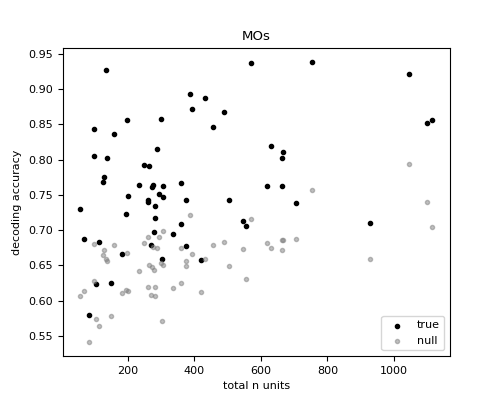

In [43]:
# "all units" accuracy versus total_n_units

sel_structure='MOs'

fig,ax=plt.subplots(1,1,figsize=(5,4))

plot_data=new_results_session_pd.query('unit_subsample_size.isna() and structure==@sel_structure')
ax.scatter(plot_data['total_n_units'],
            plot_data['mean_true'],marker='.',color='k',
            label='true')

ax.scatter(plot_data['total_n_units'],
           plot_data['median_null'],marker='.',color='gray',alpha=0.5,
           label='null')

ax.set_ylabel('decoding accuracy')
ax.set_xlabel('total n units')
ax.set_title(sel_structure)
ax.legend()


In [ ]:
# example areas: true vs. null decoding accuracy


In [ ]:
# plot on CCF?



Text(0.5, 1.0, 'MOs (r=0.24, p=0.068)')

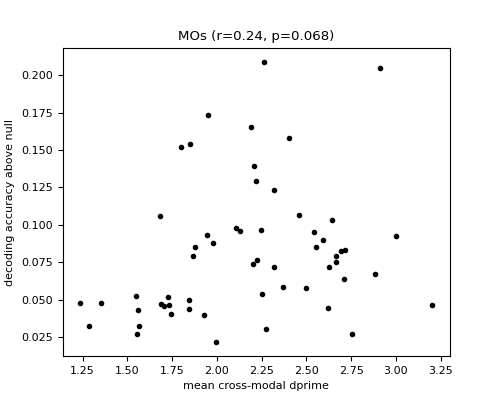

In [44]:
# correlate session-wise accuracy with cross-modal dprime

sel_structure='MOs'

fig,ax=plt.subplots(1,1,figsize=(5,4))

plot_data=new_results_session_pd.query('unit_subsample_size==20 and structure==@sel_structure')

r,p=stats.pearsonr(plot_data[['mean_cross_modal_dprime_aud_blocks',
                      'mean_cross_modal_dprime_vis_blocks']].mean(axis=1),
                    plot_data['mean_diff'])

ax.scatter(plot_data[['mean_cross_modal_dprime_aud_blocks',
                      'mean_cross_modal_dprime_vis_blocks']].mean(axis=1),
            plot_data['mean_diff'],marker='.',color='k',
            label='true')

ax.set_ylabel('decoding accuracy above null')
ax.set_xlabel('mean cross-modal dprime')
ax.set_title(sel_structure+f' (r={r:.2f}, p={p:.3f})')


In [ ]:
# compare correlation across areas?

### not seeing as strong of correlations .... why??


In [ ]:
# supplemental: plot shifts, null, etc. for a few example sessions

# also average across sessions


In [ ]:
# get all shifts for an example session and area
sel_session='742903_2024-10-22'
sel_area='MOs'

example_session_df = (
    pl.scan_parquet(results_path)
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        pl.col('session_id').eq(sel_session),
        pl.col('structure').eq(sel_area),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
    )
    .group_by(
        grouping_cols | {'repeat_idx'}
    )
    .agg(
        pl.col('balanced_accuracy_test'),
        pl.col('shift_idx').sort(),
    )
    .collect()
)





In [94]:
example_session_df.to_pandas().iloc[0]['shift_idx']

array([-43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31,
       -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18,
       -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,
        -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
         9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44], dtype=int8)

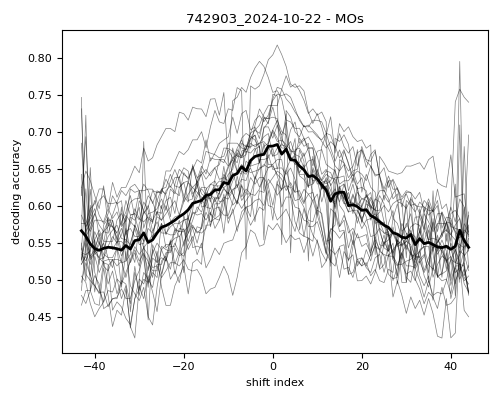

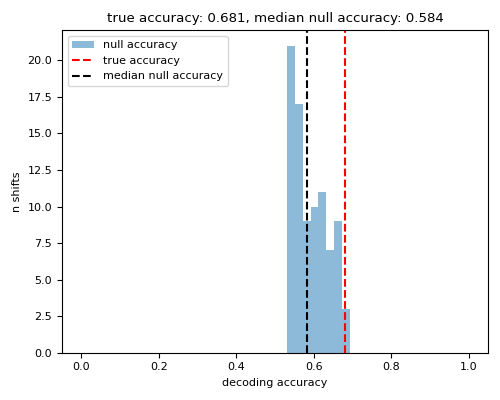

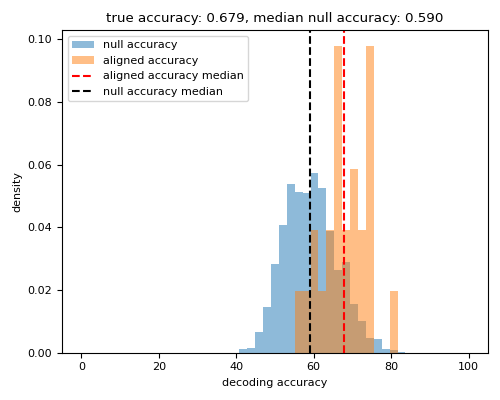

In [139]:
sel_n_units=20
example_session_area=example_session_df.to_pandas().query('unit_subsample_size==@sel_n_units')

mean_across_repeats=np.nanmean(np.vstack(example_session_area['balanced_accuracy_test'].values),axis=0)

# all_shifts_aligned=np.full((25,200),dtype=float,fill_value=np.nan)

fig,ax=plt.subplots(1,1,figsize=(5,4))
for rr, row in example_session_area.iterrows():
    ax.plot(row['shift_idx'],row['balanced_accuracy_test'],marker='',color='k',alpha=0.5,linewidth=0.5)
    ax.set_xlabel('shift index')
    ax.set_ylabel('decoding accuracy')
    ax.set_title(f'{sel_session} - {sel_area}')

#take the mean of all repeats
ax.plot(row['shift_idx'],mean_across_repeats,color='k',label='mean across repeats',linewidth=2)

fig.tight_layout()

aligned_accuracy = mean_across_repeats[row['shift_idx']==0][0]
median_null_accuracy = np.median(mean_across_repeats[row['shift_idx']!=0])

# plot the true accuracy versus the histogram of the null accuracy
fig,ax= plt.subplots(1,1,figsize=(5,4))
xbins=np.linspace(0, 1, 50)
ax.hist(mean_across_repeats[row['shift_idx']!=0], bins=xbins, alpha=0.5, label='null accuracy')
ax.axvline(aligned_accuracy, color='r', linestyle='--', label='true accuracy')
ax.axvline(median_null_accuracy, color='k', linestyle='--', label='median null accuracy')
ax.set_xlabel('decoding accuracy')
ax.set_ylabel('n shifts')
ax.set_title(f'true accuracy: {aligned_accuracy:.3f}, median null accuracy: {median_null_accuracy:.3f}')
ax.legend()
fig.tight_layout()

#get the full histogram of all shift-repeats
all_aligned_accuracy= np.vstack(example_session_area['balanced_accuracy_test'].values)[:,row['shift_idx']==0].flatten()
all_null_accuracy = np.vstack(example_session_area['balanced_accuracy_test'].values)[:,row['shift_idx']!=0].flatten()

all_aligned_accuracy_median= np.median(all_aligned_accuracy)
all_null_accuracy_median= np.median(all_null_accuracy)

fig,ax= plt.subplots(1,1,figsize=(5,4))
xbins=np.linspace(0, 100, 50)
ax.hist(all_null_accuracy*100, bins=xbins, alpha=0.5, label='null accuracy',density=True)
ax.hist(all_aligned_accuracy*100, bins=xbins, alpha=0.5, label='aligned accuracy', density=True)
ax.axvline(all_aligned_accuracy_median*100, color='r', linestyle='--', label='aligned accuracy median')
ax.axvline(all_null_accuracy_median*100, color='k', linestyle='--', label='null accuracy median')
ax.set_xlabel('decoding accuracy')
ax.set_ylabel('density')
ax.set_title(f'true accuracy: {all_aligned_accuracy_median:.3f}, median null accuracy: {all_null_accuracy_median:.3f}')
ax.legend()
fig.tight_layout()


In [106]:
# example_session_area
row['shift_idx']+100

array([  57,   58,   59,   60,   61,   62,   63,   64,   65,   66,   67,
         68,   69,   70,   71,   72,   73,   74,   75,   76,   77,   78,
         79,   80,   81,   82,   83,   84,   85,   86,   87,   88,   89,
         90,   91,   92,   93,   94,   95,   96,   97,   98,   99,  100,
        101,  102,  103,  104,  105,  106,  107,  108,  109,  110,  111,
        112,  113,  114,  115,  116,  117,  118,  119,  120,  121,  122,
        123,  124,  125,  126,  127, -128, -127, -126, -125, -124, -123,
       -122, -121, -120, -119, -118, -117, -116, -115, -114, -113, -112],
      dtype=int8)

In [107]:
all_shifts_aligned

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
# get all shifts for an example area across sessions

In [ ]:
# templeton comparison